<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import matplotlib.pyplot as plt

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language="russian") if len(x.split()) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 221797


Посчитаем для каждого слова его встречаемость.

In [8]:
words = Counter()

# Расчет встречаемости слов
for sentence in sentences:
    for word in word_tokenize(sentence):
        words[word] += 1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
sort_words = dict(sorted(words.items(), key=lambda x:x[1], reverse=True))
for word in sort_words.keys():
    vocab.add(word)
    if len(vocab) == vocab_size:
        break

vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')
vocab.add('<unk>')

In [10]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [11]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [13]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence += [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

Здесь изменю базовый код, чтобы избежать утечки из трейна

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.4)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [18]:
def train_model(model, criterion, optimizer, epochs):
    # Напишите код здесь
    losses = []
    perplexities = []
    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            
            inputs = batch['input_ids'].to(device)
            targets = batch['target_ids'].to(device)
            
            logits = model(inputs).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, targets.flatten())
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

Для первого эксперимента возьмём один GRU блок и два линейных слоя (для первого сделаем dropout с вероятностью 0.1), размер скрытого состояния возьмём 128. Обучим на 10 эпохах и в качестве оптимизатора испольуем Adam.

In [19]:
class LM1(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear= nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embedding = self.embedding(input_batch)
        output, _ = self.gru(embedding)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))
        
        return projection

In [20]:
model1 = LM1(hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion1 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer1 = torch.optim.Adam(model1.parameters())

In [21]:
# Обучите модель здесь
losses1, perplexities1 = train_model(model1, criterion1, optimizer1, 10)

Training epoch 1::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1040 [00:00<?, ?it/s]

Напишу функцию для вывода графиков и посмотрим на графики:

In [22]:
def graph(losses, per):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(losses)+1)[1:], losses, color="red")
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(1, len(per)+1), per, color="red")
    print(f"Лучшая perplexities: {(min(per)):.2f}")

    plt.title('Perplexities')
    plt.xlabel("epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

Лучшая perplexities: 116.86


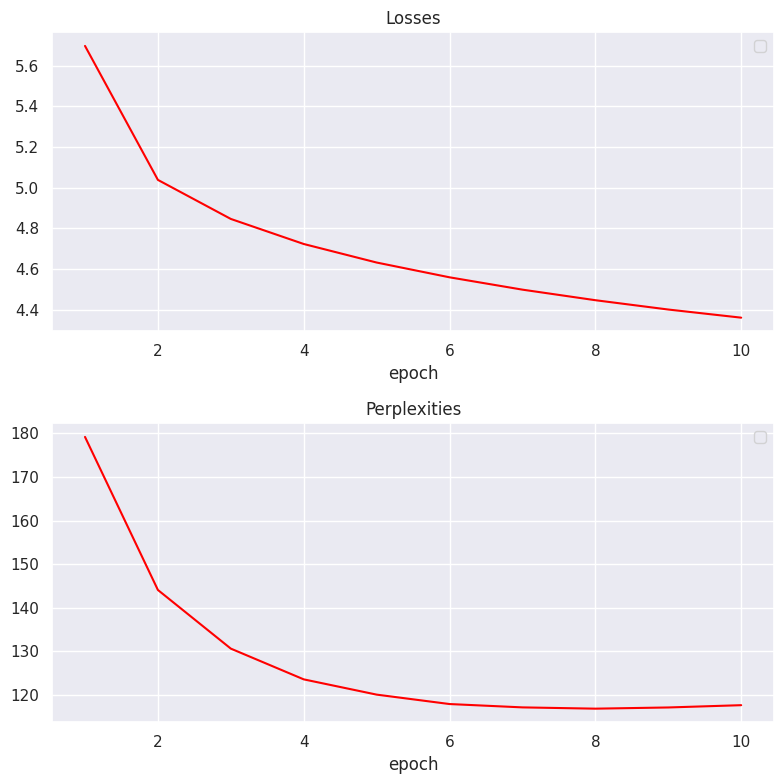

In [23]:
graph(losses1, perplexities1)

Видно, что модель после 6-7 эпохи начинает понемногу переобучаться.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Вообще, желательно делать по одному изменению, чтобы увидеть, положительно оно повлияло или нет, и так постепенно улучшать модель, но в качестве экономии времени совершу сразу несколько изменений: использую два LSTM блока, размер скрытого состояния изменю на 256 и увеличу вероятность в dropout до 0.25

In [25]:
# Проведите второй эксперимент

class LM2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear= nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embedding = self.embedding(input_batch)
        output, (hidden_state, cell_state) = self.lstm(embedding)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))
        
        return projection

In [26]:
model2 = LM2(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion2 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer2 = torch.optim.Adam(model2.parameters())

In [27]:
losses2, perplexities2 = train_model(model2, criterion2, optimizer2, 10)

Training epoch 1::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1040 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1040 [00:00<?, ?it/s]

Посмотрим на графики:

Лучшая perplexities: 127.21


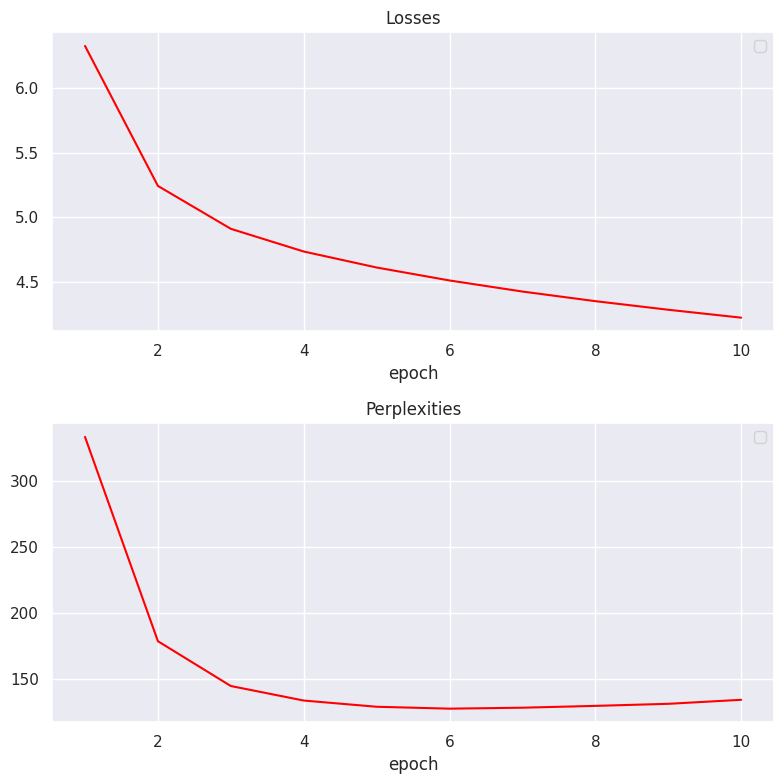

In [28]:
graph(losses2, perplexities2)

Здесь модель побольше переобучилась, и даже лучший результат оказался хуже, чем у прошлой модели.

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

В идеале, как я уже и писал выше, надо было бы добавлять по одному изменению, и в зависимости от результата решать, оставлять его или нет, и так постепенно изменять архитектуру в лучшую сторону. Но это всё заняло бы слишком много времени. Я провёл два эксперимента, и как по мне второй должен был оказаться лучше, но этого не произошло, перплексия на первом эксперименте оказалась меньше, также вторая модель больше переобучилась, надо было уменьшить кол-во эпох, но даже учитывая это, первая модель показала себя лучше. До того, как пофиксил разделение на трейн/вал/тест перплексия была в раза 2 меньше, и вторая модель показывала результат получше (около 50), что логично, так как она чуть больше переобучилась. Посмотрим значения на тесте (вообще стоило бы сохранять лучшую модель на определённой эпохе, но я тупанул, в принципе переобучение небольшое, поэтому не так критично):

In [24]:
print(f"Перплекися для модели из первого эксперимента на тесте: {evaluate(model1, criterion1, test_dataloader):.2f}")

Перплекися для модели из первого эксперимента на тесте: 116.92


In [29]:
print(f"Перплекися для модели из второго эксперимента на тесте: {evaluate(model2, criterion2, test_dataloader):.2f}")

Перплекися для модели из второго эксперимента на тесте: 132.95


В качестве улучшений, в первую очередь я бы уменьшил кол-во эпох и поигрался бы с кол-вом GRU/LSTM блоков. Ещё можно поизменять значения гиперпараметров или добавить что-нибудь новое (напримет батчнорм.).  
Дополнительно напишу код для генерации предложений:

In [34]:
def generation(model, start: str, max_words: int = 32):
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(start)]
    len_seq = len(input_ids)
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_words - len_seq):
            next_word = model(input_ids)[-1].squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
                
    seq = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return seq

Попробуем для первой модели (которая показала лучший результат):

In [39]:
print(generation(model1, "i like this movie"))
print(generation(model1, "i hate it because"))
print(generation(model1, "he never"))

<bos> i like this movie , but i was n't expecting it to be a movie . <eos>
<bos> i hate it because it 's a good movie . <eos>
<bos> he never got to be a good actor . <eos>


Теперь для второй:

In [40]:
print(generation(model2, "i like this movie"))
print(generation(model2, "i hate it because"))
print(generation(model2, "he never"))

<bos> i like this movie , but i do n't think it was a good movie . <eos>
<bos> i hate it because it was a good movie . <eos>
<bos> he never made the film . <eos>


Вроде очень даже неплохо)